# PCA METHOD

### 1. Importing libraries

In [1]:
import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import src.data.preprocessing as pre

from skimage import io
from sklearn.decomposition import PCA

### 2. Loading images

In [2]:
directory = "images"

data = np.zeros((13804, 60, 60))

for index, filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    img = io.imread(f)
    
    if img.shape[2] < 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = pre.preprop_hachaj(img)
        img = pre.mass_mean(img)
        img = pre.rotate(img)
        data[index, :, :] = img


89.0


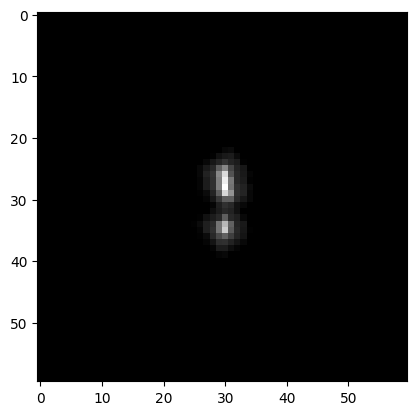

In [3]:
#przykladowy obraz
image = data[68]
plt.imshow(image, cmap="gray")
print(image.max())

In [4]:
#reshape danych pod cechy pca
data = data.reshape(13804, 3600)

In [5]:
#skalowanie cech
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)

data = scaler.transform(data)

In [102]:
#dokonanie pca
#variancja większa niz 0.95 !!!
pca = PCA(n_components=60)
pca.fit(data)
print(sum(pca.explained_variance_ratio_))


0.9571173679777817


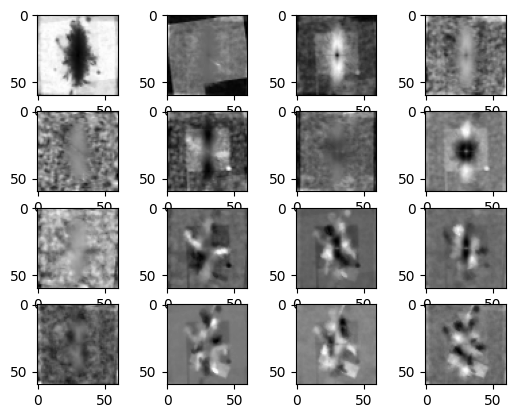

In [7]:
#wizualizacja cech
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pca.components_[i].reshape((60, 60)), cmap="gray")

(3600,)


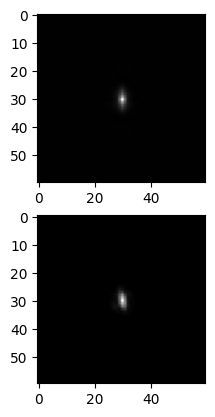

In [8]:
#odwtorzenie przykladowego zdjecia z algorytmu pca
liczba = 30

img = pca.transform(data[liczba].reshape((1, 3600)))

obraz = np.zeros(3600)

for index, item in enumerate(img[0]):
    obraz += item*pca.components_[index]


print(obraz.shape)

obraz1 = scaler.inverse_transform(np.array([obraz])).reshape((60, 60))
obraz2 = scaler.inverse_transform(np.array([data[liczba]])).reshape((60, 60))

plt.subplot(2, 1, 1)

plt.imshow(obraz1, cmap="gray")

plt.subplot(2, 1, 2)
plt.imshow(obraz2, cmap="gray")

In [9]:
#srednia roznica obu obrazow
diff = abs(np.subtract(obraz1, obraz2))
sum_diff = sum(sum(diff))/len(diff)
print(sum_diff)

3.6184960096995464


In [10]:
#zamiana wszystkich obrazow 

lista = []

for i in range(13804):
    img = pca.transform(data[i].reshape((1, 3600)))
    obraz = np.zeros(3600)
    for index, item in enumerate(img[0]):
        obraz += item*pca.components_[index]

    obraz1 = scaler.inverse_transform(np.array([obraz])).reshape((60, 60))
    obraz2 = scaler.inverse_transform(np.array([data[i]])).reshape((60, 60))
    diff = abs(np.subtract(obraz1, obraz2))
    sum_diff = sum(sum(diff))/len(diff)
    lista.append(sum_diff)
    

In [11]:
lista = np.array(lista)
print(max(lista))
print(min(lista))

print(lista.argmin())
print(lista.argmax())

128.4120598724882
0.969982028784863
3484
8934


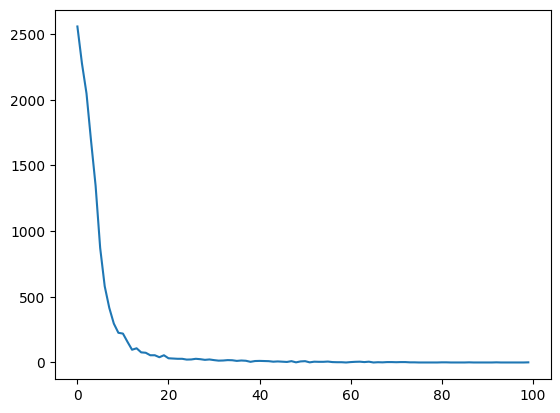

In [22]:
#histogram pokazujący skutecznośc pca, czyli jak bardzo obraz pierwotny rozni sie od rozkladu
a, b = np.histogram(lista, 100)

plt.plot(a)

In [90]:
#proba klastrowania cech
from sklearn.cluster import DBSCAN

dane = pca.transform(data)

dbscan_opt=DBSCAN(eps=1,min_samples=2)
dbscan_opt.fit(dane)

DBSCAN(eps=1, min_samples=2)

In [91]:
labels = dbscan_opt.labels_
unique_labels = set(dbscan_opt.labels_)
print(len(unique_labels))
print(len(labels) - np.count_nonzero(labels))

133
9471


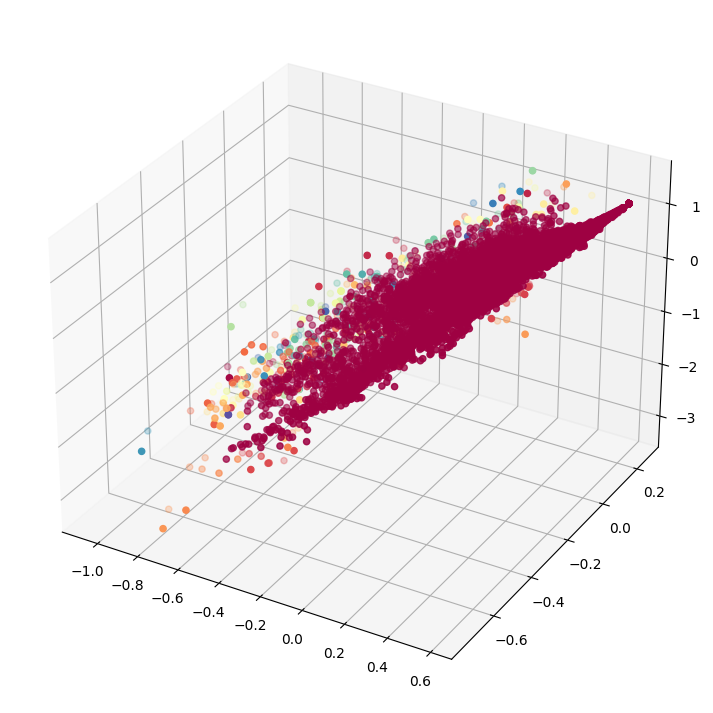

In [101]:
#wizualizacja graficzna stosunku pierwszych 3 cech dla zdjęć
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")


core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan_opt.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = dane[class_member_mask & core_samples_mask]
    ax.scatter3D(
        xy[:, 0],
        xy[:, 1],
        xy[:, 2],
        color=tuple(col)
    )